In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
import matplotlib.animation as animation
import pandas as pd
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [2]:
class Espira:
    def __init__(self, ke, me, y_i, v_i, primeira=False, ultima=False):
        self.ke = ke
        self.me = me
        self.primeira = primeira
        self.ultima = ultima

        self.v = v_i
        self.y = y_i


    def edo_y(self):
        return self.v

    def edo_v(self, g, y_antes, y_depois):
        if not self.primeira and not self.ultima:
            valor = -g + (-((self.ke/self.me)*abs(y_depois - self.y)) + ((self.ke/self.me)*abs(self.y - y_antes)))
        elif self.primeira:
            valor = -g - ((self.ke/self.me)*abs(y_depois - self.y))
        else:
            valor = -g + ((self.ke/self.me)*abs(self.y - y_antes))

        return round(valor, 4)

    def __str__(self):
        return f'espira(ke={self.ke}, me={self.me}, y_i={self.y}, v_i={self.v}, primeira={self.primeira}, ultima={self.ultima})'

class mola:
    def __init__(self, N, k, m, L, g=10):
        self.original_N = N
        self.N = N
        self.k = k
        self.m = m
        self.g = g
        self.L = L
        self.espiras = []

    def reset(self):
        self.N = self.original_N
        self.espiras = []
        for i in range(self.original_N):
            self.espiras.append(
                Espira(
                    ke = self.k*(self.original_N-1),
                    me = self.m/self.original_N,
                    y_i = 0,
                    v_i = 0,
                    primeira = i == 0,
                    ultima = i == (self.original_N - 1)
                    # primeira = False,
                    # ultima = False,
                )
            )

        self.espiras[0].y = 0
        y_anterior = 0
        for idx, espira in enumerate(self.espiras[1:]):
            correct_idx = idx+1 #enumerate começa no 0, apenas idx vai fazer a mola levar em conta a massa da anterior
            somatorio = (-self.g/espira.ke)*sum([e.me for e in self.espiras[correct_idx:]])
            espira.y = y_anterior + somatorio
            y_anterior = espira.y

    def passo_euler(self, step):
        new_y = []
        new_v = []
        for idx, espira in enumerate(self.espiras):
            y_antes = self.espiras[idx-1].y if idx > 0 else 0
            y_depois = self.espiras[idx+1].y if idx < self.N-1 else 0
            new_y.append(espira.y + step*espira.edo_y())
            new_v.append(espira.v + step*espira.edo_v(self.g, y_antes, y_depois))

        for idx, espira in enumerate(self.espiras):
            espira.y = new_y[idx]
            espira.v = new_v[idx]

        if len(self.espiras) > 1 and self.espiras[0].y <= self.espiras[1].y:
            self.colisao()

    def colisao(self):
        espira1 = self.espiras.pop(0)
        espira2 = self.espiras.pop(0)

        m_res = espira1.me + espira2.me
        v_res = (espira1.me*espira1.v + espira2.me*espira2.v)/m_res

        espira_res = Espira(
            ke = espira1.ke,
            me = m_res,
            y_i = espira2.y,
            v_i = v_res,
            primeira = True,
            ultima = len(self.espiras) == 1
        )

        self.espiras.insert(0, espira_res)
        self.N = self.N-1

    def plot_wave(self, start, end, f=1):
        amplitude = 0.1
        wavelength = end - start
        x = np.linspace(start, end, 1000)
        y = amplitude * np.sin(2 * np.pi * (x - start) * f / wavelength)
        return x, y

    def plot_slinky(self, initial_size=True):
        i = 0
        x_arr = np.array([])
        y_arr = np.array([])
        if len(self.espiras) > 1:
            for espira1, espira2 in zip(self.espiras[:-1], self.espiras[1:]):
                if i == 0 and initial_size:
                    x, y = self.plot_wave(espira1.y+self.L, espira1.y, ((self.original_N+1)-self.N))
                    x_arr = np.concatenate((x_arr ,x))
                    y_arr = np.concatenate((y_arr ,y))

                x, y = self.plot_wave(espira1.y, espira2.y, 1)
                x_arr = np.concatenate((x_arr ,x))
                y_arr = np.concatenate((y_arr ,y))
                i += 1
        else:
            x, y = self.plot_wave(self.espiras[0].y-self.L, self.espiras[0].y, self.original_N)
            x_arr = np.concatenate((x_arr ,x))
            y_arr = np.concatenate((y_arr ,y))

        return x_arr, y_arr

    def __str__(self):
        espiras_str = '\n'.join([str(espira) for espira in self.espiras])
        return f'mola(N={self.N}, k={self.k}, m={self.m})\nEspiras:\n{espiras_str}'


In [3]:
def animar_mola(
        modelo,
        nome_animacao,
        step=0.001,
        velocidade_video=1,
        initial_size=True,
        xlim=(-2, 2),
        ylim=(-2, 0.2),
):
    modelo.reset()

    fig = plt.figure()
    axis = plt.axes(
        xlim =xlim,
        ylim =ylim
    )

    line, = axis.plot([], [], lw = 2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        modelo.passo_euler(step=step)
        x, y = modelo.plot_slinky(initial_size=initial_size)
        line.set_data(y, x)

        return line,

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func = init,
        frames = int(1//step),
        interval = 0,
        blit = True
    )

    anim.save(f'{nome_animacao}.mp4', writer='ffmpeg', fps=(1/step)*velocidade_video)

def posicoes_espiras(
        modelo,
        step=0.001,
        tempo_max=0.45,
        N=10,
):
    modelo.reset()

    posicao_espiras = []
    for i in range(int(1//step)):
        espiras = np.array([modelo.espiras[0].y for e in range(N-len(modelo.espiras))] + [espira.y for espira in modelo.espiras])
        posicao_espiras.append(espiras)
        modelo.passo_euler(step=step)
    
    
    X_espira0 = [espiras[0] for espiras in posicao_espiras[:int(tempo_max//step)]]
    X_espira2 = [espiras[2] for espiras in posicao_espiras[:int(tempo_max//step)]]
    X_espira5 = [espiras[4] for espiras in posicao_espiras[:int(tempo_max//step)]]
    X_espira6 = [espiras[6] for espiras in posicao_espiras[:int(tempo_max//step)]]
    X_espira9 = [espiras[9] for espiras in posicao_espiras[:int(tempo_max//step)]]

    y_axis = np.arange(0, int(tempo_max//step), int(tempo_max//step)/len(X_espira0))*step

    posicao_espiras = np.array(posicao_espiras)
    plt.plot(y_axis, X_espira0)
    plt.plot(y_axis, X_espira2)
    plt.plot(y_axis, X_espira5)
    plt.plot(y_axis, X_espira6)
    plt.plot(y_axis, X_espira9)
    # plt.plot([espiras[10] for espiras in posicao_espiras[:int(tempo_max//step)]])
    # plt.plot([espiras[N*2//5] for espiras in posicao_espiras[:int(tempo_max//step)]])
    # plt.plot([espiras[N*3//5] for espiras in posicao_espiras[:int(tempo_max//step)]])
    # plt.plot([espiras[N*4//5] for espiras in posicao_espiras[:int(tempo_max//step)]])
    # plt.plot([espiras[N-1] for espiras in posicao_espiras[:int(tempo_max//step)]])

    # plt.xticks(np.arange(0, int(tempo_max//step), int(tempo_max/10/step)), np.arange(0, int(tempo_max//step), int(tempo_max/10/step))*step, )
    # plt.xlabel('s')
    # plt.ylabel('m')
    # plt.xticks(rotation=45)

    return posicao_espiras


In [4]:
modelos = {
    'metal': mola(N=10, L=0.0722, m=0.2510, g=9.81,  k=0.6556369155,),
    'plastico': mola(N=10, L=0.0722, m=0.0437, g=9.81, k=0.1160296315),
    'molinha': mola(N=10, L=0.02794, m=0.0971, g=9.81, k=1.8892324474),
}

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

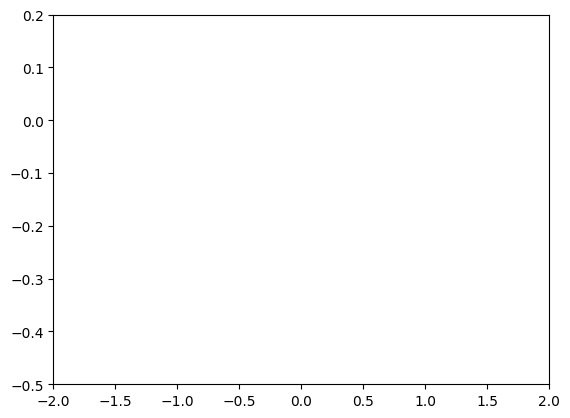

In [5]:
for nome, modelo in modelos.items():
    animar_mola(modelo=modelo, nome_animacao=nome, velocidade_video=1/3, ylim=(-0.5, 0.2))

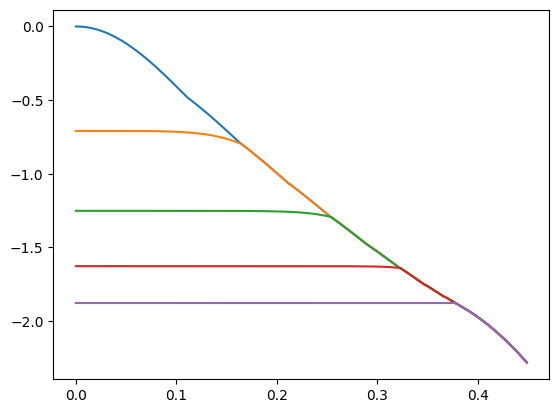

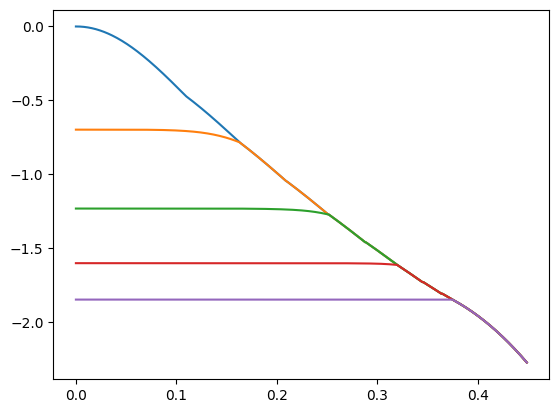

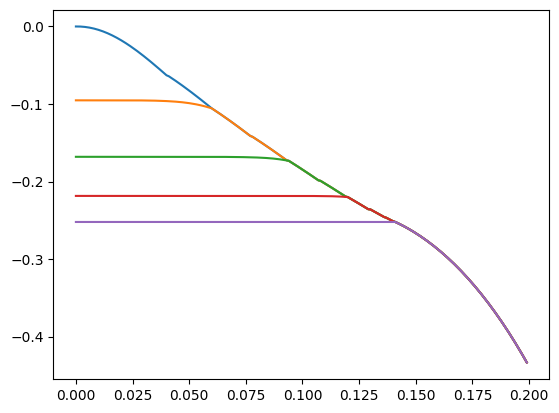

In [8]:
df = []

for nome, modelo in modelos.items():
    if nome == 'molinha':
        df.append(posicoes_espiras(modelo, tempo_max=0.2))
    else:
        df.append(posicoes_espiras(modelo))

    plt.savefig(f'{nome}.png')
    plt.show()

In [ ]:
analysis_df = pd.DataFrame(df[0])
tempo_queda_metal = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

analysis_df = pd.DataFrame(df[1])
tempo_queda_plastico = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

analysis_df = pd.DataFrame(df[2])
tempo_queda_molinha = analysis_df[analysis_df[9] == analysis_df[8]].index[0]*0.001

tempo_queda_metal, tempo_queda_plastico, tempo_queda_molinha

In [ ]:
# modelos_doidos = {
#     'lua': mola(N=100, L=0.0722, m=0.2510, g=1.62, k=0.6556369155,),
#     'jupiter': mola(N=100, L=0.0722, m=0.2510, g=24.79, k=0.6556369155,),
#     'super_mola': mola(N=100, L=0.0722, m=25.10, g=200, k=2000,),
# }
# # 0.6556369155*(0.0722**2)/0.2510


In [ ]:
teste = mola(N=10, L=0.0722, m=0.2510, g=10, k=0.6556369155)
teste.reset()
x, y = teste.plot_slinky()
plt.plot(y, x)
plt.xlim([-0.5, 0.5])
teste1 = [espira.y for espira in teste.espiras]

0
1
2
3
4
5
6
7
8


[0,
 -0.3828338430403711,
 -0.7231305924095899,
 -1.0208902481076563,
 -1.2761128101345705,
 -1.4887982784903322,
 -1.6589466531749415,
 -1.7865579341883986,
 -1.8716321215307032,
 -1.9141692152018557]

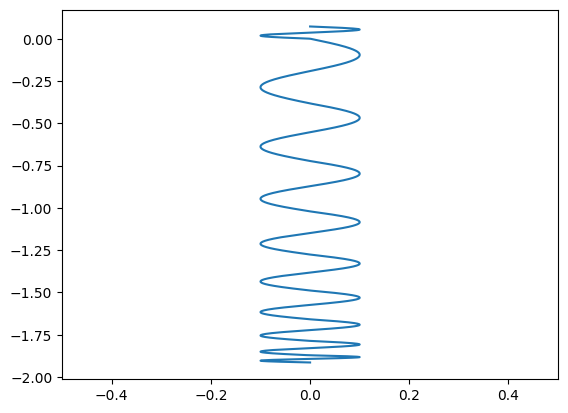

In [91]:
teste = mola(N=10, L=0.0722, m=0.2510, g=10, k=0.6556369155)
teste.reset()
x, y = teste.plot_slinky()
plt.plot(y, x)
plt.xlim([-0.5, 0.5])
[espira.y for espira in teste.espiras]

In [ ]:
abs(np.array(teste1)-np.array(teste2))

In [ ]:
teste1, teste2

In [ ]:
# for nome, modelo in modelos_doidos.items():
#     animar_mola(modelo=modelo, nome_animacao=nome, velocidade_video=1/3)

In [ ]:
# df = []
#
# for nome, modelo in modelos_doidos.items():
#     if nome == 'super_mola':
#         df.append(posicoes_espiras(modelo, step=0.0000001, tempo_max=0.005, N=100))
#     else:
#         df.append(posicoes_espiras(modelo))
#
#     # plt.yscale('log')
#     # plt.gca().invert_yaxis()
#     # plt.savefig(f'{nome}.png')
#     plt.show()

In [ ]:
df = pd.read_csv("experimental.csv")

# Lista de molas presentes no DataFrame
molas = df['Mola'].unique()

# Criar gráfico para cada mola
for mola in molas:
    df_mola = df[df['Mola'] == mola]

    plt.figure(figsize=(8, 5), facecolor='white')
    plt.xlabel("Tempo (s)")
    plt.ylabel("Posição (m)")
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # Adiciona linhas para cada espira
    plt.scatter(
        df_mola['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_mola['Posição (metro) Espira 1'].str.replace(',', '.').astype(float),
        marker='x',
        label='Primeira Espira',
        color='blue'
    )

    plt.scatter(
        df_mola['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_mola['Posição (metro) Espira meio'].str.replace(',', '.').astype(float),
        marker='x',
        label='Espira central',
        color='green'
    )

    plt.scatter(
        df_mola['Tempo (s)'].str.replace(',', '.').astype(float),
        -df_mola['Posição (metro) Espira ultima'].str.replace(',', '.').astype(float),
        marker='x',
        label='Última espira',
        color='purple'
    )

    # if mola == 1:
    #     posicoes_espiras(modelos['metal'])
    #
    # if mola == 2:
    #     posicoes_espiras(modelos['plastico'])
    #
    # if mola == 3:
    #     posicoes_espiras(modelos['molinha'], tempo_max=0.2)


    plt.legend()
    plt.grid(True)
    plt.savefig(f'{mola}')
    plt.show()